## VinBigData Chest X-ray Abnormalities Detection
### Automatically localize and classify thoracic abnormalities from chest radiographs


![LhW7qsw.png](https://i.imgur.com/LhW7qsw.png)

## Data Description

Data Description In this competition, we are classifying common thoracic lung diseases and localizing critical findings. This is an object detection and classification problem.

For each test image, you will be predicting a bounding box and class for all findings. If you predict that there are no findings, you should create a prediction of "14 1 0 0 1 1" (14 is the class ID for no finding, and this provides a one-pixel bounding box with a confidence of 1.0).

The images are in DICOM format, which means they contain additional data that might be useful for visualizing and classifying.

**Dataset information**
The dataset comprises 18,000 postero-anterior (PA) CXR scans in DICOM format, which were de-identified to protect patient privacy. All images were labeled by a panel of experienced radiologists for the presence of 14 critical radiographic findings as listed below:

> 0 - Aortic enlargement 1 - Atelectasis 2 - Calcification 3 - Cardiomegaly 4 - Consolidation 5 - ILD 6 - Infiltration 7 - Lung Opacity 8 - Nodule/Mass 9 - Other lesion 10 - Pleural effusion 11 - Pleural thickening 12 - Pneumothorax 13 - Pulmonary fibrosis

**Aortic enlargement** == An abnormal bulge that occurs in the wall of the major blood vessel.

**Atelectasis** == Collapse of a part of the lung due to a decrease in the amount of air in the alveoli resulting in volume loss and increased density.

**Calcification** == Deposition of calcium salts in the lung.

**Cardiomegaly** == Enlargement of the heart, occurs when the heart of an adult patient is larger than normal and the cardiothoracic ratio is greater than 0.5.
Consolidation == Any pathologic process that fills the alveoli with fluid, pus, blood, cells (including tumor cells) or other substances resulting in lobar, diffuse or multifocal ill-defined opacities.

**Interstitial lung disease (ILD)** == Involvement of the supporting tissue of the lung parenchyma resulting in fine or coarse reticular opacities or small nodules.

**Infiltration** == An abnormal substance that accumulates gradually within cells or body tissues or any substance or type of cell that occurs within or spreads as through the interstices (interstitium and/or alveoli) of the lung, that is foreign to the lung, or that accumulates in greater than normal quantity within it.

**Lung opacity** == Any abnormal focal or generalized opacity or opacities in lung fields (blanket tag including but not limited to consolidation, cavity, fibrosis, nodule, mass, calcification, interstitial thickening, etc.)

**Nodule/Mass** == Any space occupying lesion either solitary or multiple.

**Other lesion**== Other lesions that are not on the list of findings or abnormalities mentioned above.

**Pleural effusion** == Abnormal accumulations of fluid within the pleural space.

**Pleural thickening** == Any form of thickening involving either the parietal or visceral pleura.

**Pneumothorax **== The presence of gas (air) in the pleural space.

**Pulmonary fibrosis** == An excess of fibrotic tissue in the lung.**

### import library

In [ ]:
import sys
print(sys.executable)

In [ ]:
import os
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

print("Python version used = ", sys.version)
print("Numpy version used = ", np.__version__)
print("OpenCV version used = ", cv2.__version__)
print("pydicom version used = ", pydicom.__version__)

In [ ]:
train = pd.DataFrame(pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv"))

print("Shape of dataframe = ", train.shape)

In [ ]:
train.head()

In [ ]:
train['class_name'].value_counts()

In [ ]:
train_class_distribution = train['class_name'].value_counts().sort_values()

In [ ]:
train.info()

So, we have significant missing values in our dataset. Let's see the exact NaN count per feature. 

Different colormaps available can be found here : [matplotlib_colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

In [ ]:
train.isna().sum().to_frame().rename(columns = {0 : "NaN_count"}).style.background_gradient(cmap = "copper")

## A Note On Dataset Feature - Class ID: 

Following are the class names and ids which are used on the metadata dataframe.

* 0 - Aortic enlargement
* 1 - Atelectasis
* 2 - Calcification
* 3 - Cardiomegaly
* 4 - Consolidation
* 5 - ILD
* 6 - Infiltration
* 7 - Lung Opacity
* 8 - Nodule/Mass
* 9 - Other lesion
* 10 - Pleural effusion
* 11 - Pleural thickening
* 12 - Pneumothorax
* 13 - Pulmonary fibrosis
* 14 - No Finding(healthy)

In [ ]:
map_name_to_id = {
    "Aortic enlargement" : 0,
    "Atelectasis" : 1,
    "Calcification" : 2,
    "Cardiomegaly" : 3,
    "Consolidation" : 4,
    "ILD" : 5,
    "Infiltration" : 6,
    "Lung Opacity" : 7,
    "Nodule/Mass" : 8,
    "Other lesion" : 9,
    "Pleural effusion" : 10,
    "Pleural thickening" : 11,
    "Pneumothorax" : 12,
    "Pulmonary fibrosis" : 13,
    "No Finding(healthy)" : 14
}

# Class Name : 

Though we know there are 14 + 1(no finding) classes into which images are classified, and a single image may be diagnosed with multiple diseases, hence it becomes imperative to at least check whether the labels are available altogether in one entry(*we have to separate them if that's the case*), or the entry is repeated in the dataframe, having new label corresponding to it, till all the classes it's been diagnosed with are covered.

In [ ]:
train.class_name.unique(), len(train.class_name.unique())

So, we don't have a scenario where labels are merged like *"Aortic enlargmenet| Lung opacity"*, which we would have to separate otherwise.

# Label Count : 

In [ ]:
label_count = dict()
for label in tqdm(train.class_id.values) : 
    if label not in label_count : 
        label_count[label] = 1
    else:
        label_count[label] += 1

labels = ["Aortic Enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung Opacity", "Nodule/Mass",
         "Other lesion", "Pleural effusion", "Pleural thickening", "Pneumothorax", "Pulmonary fibrosis", "No finding"]
counts = [label_count[0], label_count[1], label_count[2], label_count[3], label_count[4], label_count[5], label_count[6], label_count[7], label_count[8],
         label_count[9], label_count[10], label_count[11], label_count[12], label_count[13], label_count[14]]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

fig, ax = plt.subplots(figsize = (20, 12))
ax.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
ax.axis("equal")

**Inference** : 

In terms of skewness, it's quite a number. We can observe nearly 45%+ cases thankfully healthy(no-finding), however the diseased ones, the distribution of diseases is skewed. From overall perspective too, the imbalance is high enough to ring danger alarms! Down the line, this will have to be addressed.

# Radiologist Contribution Imbalance Study

As we have several radiologists labeling each image, it might be helpful to know whether there is existing of an imbalance in their respective work. Let's have a look at that.

In [ ]:
train.rad_id.unique()

In [ ]:
r_count = dict()
for rad_id in train.rad_id.values : 
    if rad_id in r_count : 
        r_count[rad_id] += 1
    else:
        r_count[rad_id] = 1

rad_ids = ['R11', 'R7', 'R10', 'R9', 'R17', 'R3', 'R8', 'R6', 'R5', 'R4', 'R2', 'R16', 'R1', 'R15', 'R13', 'R12', 'R14']
counts = [r_count['R11'], r_count['R7'], r_count['R10'], r_count['R9'], r_count['R17'], r_count['R3'], r_count['R8'], r_count['R6'],
         r_count['R5'], r_count['R4'], r_count['R2'], r_count['R16'], r_count['R1'], r_count['R15'], r_count['R13'], r_count['R12'], r_count['R14']]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

fig, ax = plt.subplots(figsize = (20, 12))
ax.pie(counts, explode = explode, labels = rad_ids, shadow = True, startangle = 90)
ax.axis("equal")

So, yes there is heavy imbalance when contribution of radiologists are concerned. R10, R9 and R8 collectively dominate the overall space!

# A Note ON DICOM File Format : 

![O8sWTt0.jpg](https://i.imgur.com/O8sWTt0.jpg)


DICOM stands for **Digital Imaging and Communications in Medicine**. It is a standard, internationally accepted format to view, store, retrieve and share medical images. DICOM conforms to set protocols to maintain accuracy of information relayed through medical images. 

Any DICOM medical image consists of two parts — **a header and the actual image itself**. 

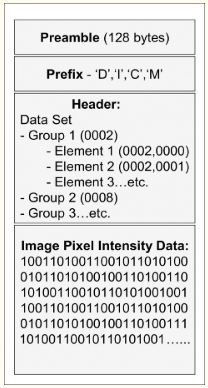

* The header consists of data that describes the image, the most important being patient data. This includes the patient’s demographic information such as the patient’s name, age, gender, and date of birth. 
* The header may also give information on image characteristics such as acquisition parameters, pixel intensity, matrix size, and dimensions of the image. All info in DICOM(.dcm) files are provided using **separate tags**. 

16 bit DICOM images have values ranging from -32768 to 32768 while 8-bit grey-scale images store values from 0 to 255. The value ranges in DICOM images are useful as they correlate with the Hounsfield Scale which is a quantitative scale for describing radio-density (or a way of viewing different tissues densities).

## Hounsfield Units : 

The Hounsfield Units (HU) make up the grayscale in medical CT imaging. **It is a scale from black to white of 4096 values (12 bit) and ranges from -1024 HU to 3071 HU (zero is also a value). It is defined by the following:**

*-1024 HU is black and represents air (in the lungs). 0 HU represents water (since we consist mostly out of water, there is a large peak here). 3071 HU is white and represents the densest tissue in a human body, tooth enamel. All other tissues are somewhere within this scale; fat is around -100 HU, muscle around 100 HU and bone spans from 200 HU (trabecular/spongeous bone) to about 2000 HU (cortical bone).**

Metal implants typically have very high Hounsfield units. Therefore, they are attributed the maximum value in typical 12-bit CT scans (3071).

## DICOM LUT : 

* **Modality LUT** : A "Modality LUT " allows the transformation of manufacturer-dependent pixel values into manufacturer-independent pixel values (e.g., Hounsfield units for CT images). 
* **VOI LUT** : A "VOI LUT" allows the transformation of the modality pixel values into pixel values that are meaningful for print or display. This transformation is applied after any "Modality LUT".

# DICOM to Numpy Tensor : 

Insights taken from  : **[raddar notebook](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way)**

Raw dicom data is not actually linearly convertable to "human-friendly" png/jpg. In fact, most of DICOM's store pixel values in exponential scale.

So in order to get jpg/png we need to apply some transformations. DICOM metadata stores information how to make such "human-friendly" transformations.

## Fix Monochrome : 

Regarding fix_monochrome, we use that since .dcm images contains many shades of grey and black in it. Hence, to bring down it to the same level (normalize), we do this. It helps in getting better insights from the medical images. Also, MONOCHROME2 images have intensities inverted vs MONOCHROME1. One goes from 0=air to XXXX=bone, while the other goes from 0=bone to XXXX=air. Hence the operation `data = np.amax(data) - data` is needed.

In [ ]:
def dicom2numpy(path, voi_lut = True, fix_monochrome = True) : 
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut == True : 
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    if fix_monochrome == True and dicom.PhotometricInterpretation == "MONOCHROME1" : 
        data = np.amax(data) - data
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [ ]:
sample_image1 = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/0007d316f756b3fa0baea2ff514ce945.dicom")
print("Shape = ", sample_image1.shape)



#plt.imshow(dcm.pixel_array,cmap='gray')

plt.figure(figsize = (20, 12))
plt.imshow(sample_image1,cmap='gray')
plt.grid(False)
plt.title("Sample Image", fontsize = 16)

In [ ]:

# importing required libraries of opencv 
import cv2 
  
# importing library for plotting 
from matplotlib import pyplot as plt 
  
# reads an input image 
sample_image1 = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/0007d316f756b3fa0baea2ff514ce945.dicom")
print("Shape = ", sample_image1.shape)


  
# find frequency of pixels in range 0-255 
histr = cv2.calcHist([sample_image1],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 

plt.plot(histr) 
plt.show() 

In [ ]:
sample_image2 = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/006e2726c6aa72f042a08b1406c39d52.dicom")
print("Shape = ", sample_image2.shape)



#plt.imshow(dcm.pixel_array,cmap='gray')

plt.figure(figsize = (20, 12))
plt.imshow(sample_image2,cmap='gray')
plt.grid(False)
plt.title("Sample Image", fontsize = 16)

In [ ]:

# importing required libraries of opencv 
import cv2 
  
# importing library for plotting 
from matplotlib import pyplot as plt 
  
# reads an input image 
sample_image2 = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/006e2726c6aa72f042a08b1406c39d52.dicom")
print("Shape = ", sample_image2.shape)


  
# find frequency of pixels in range 0-255 
histr = cv2.calcHist([sample_image2],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 

plt.plot(histr) 
plt.show() 

In [ ]:
plt.figure(figsize = (20, 20))

plt.subplot(1,3,1)
sample_image = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom")
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image", fontsize = 18)

plt.subplot(1,3,2)
sample_image = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom", voi_lut = False)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image + VOI_LUT = False", fontsize = 18)

plt.subplot(1,3,3)
sample_image = dicom2numpy("../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom", fix_monochrome = False)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image + Fix Monochrome = False", fontsize = 18)


Also, let's look at the metadata header of DICOM as well.

In [ ]:
print(pydicom.read_file("../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom"))

Extracting Metadata from this.

In [ ]:
train_image_ids = train.image_id.unique() # one person might have multiple diseases.
print("Number of unique IDS = ", len(train_image_ids))

In [ ]:
rows = []
columns = []
sex = []
for pat_id in tqdm(train_image_ids) : 
    path = "../input/vinbigdata-chest-xray-abnormalities-detection/train/"+pat_id+".dicom"
    dicom_file = pydicom.read_file(path, stop_before_pixels = True)
    rows.append(dicom_file.Rows)
    columns.append(dicom_file.Columns)
    sex.append(dicom_file.PatientSex)

additional_metadata = pd.DataFrame({
    "image_id" : train_image_ids,
    "rows" : rows,
    "columns" : columns,
    "sex" : sex
})

print("Shape of additional metadata frame = ", additional_metadata.shape)
additional_metadata.head()

# Gender Analysis

In [ ]:
male_count = len(additional_metadata[additional_metadata["sex"] == "M"])
female_count = len(additional_metadata[additional_metadata["sex"] == "F"])

print("Male : Female Ratio = ", male_count / female_count )

This is quite a healthy ratio between both genders. However, before closing the book on this one, let's cross confirm whether there are other genders too, in the dicom dataset.

In [ ]:
additional_metadata.sex.unique()

Indeed, there are. Let's have a look at the count of them all.

In [ ]:
plt.figure(figsize = (12, 8))
sns.countplot(additional_metadata["sex"], palette = "dark")
plt.grid(True)
plt.axis('on')
plt.title("Gender Count", fontsize = 18)

# Shape Analysis

In [ ]:
plt.figure(figsize = (20, 12))
x = additional_metadata["rows"]
y = additional_metadata["columns"]
plt.scatter(x, y, cmap = "plasma", label = "Training Images")
plt.title("Shape Analysis Of Training Images", fontsize = 18)
plt.xlabel("Number Of Rows", fontsize = 18)
plt.ylabel("Number Of Columns", fontsize = 18)
plt.grid(True)
plt.axis('on')
plt.legend()

Majority of images have rows in range [2500, 3000] and columns = [2000, 3000].

## Image Pixel Encapsulation

Higher pixel count directly corresponds to quality and size of the image. Let's have a look at that too.

In [ ]:
plt.figure(figsize = (12, 8))
x = additional_metadata["rows"]
y = additional_metadata["columns"]
sns.distplot(x * y, kde = True, color = "brown")
plt.xlabel("pixel count", fontsize = 16)
plt.title("Pixel Count Analysis", fontsize = 18)
plt.grid(True)
plt.axis("on")

# Bounding Box Visualization

In [ ]:
train.head()

We are only interested in visualizing bounding boxes. However, a good fraction of the bulk is healthy. So, it seems wise to drop it for this visualization purpose, as no bounding box exists for these cases. In dataframe, all coordinates are marked by NaN, indicating this fact.

In [ ]:
df = train[train["class_id"] != 14]

images = []
image_ids = df.image_id.values
class_ids = df.class_id.unique()

# map label id to a random color(distinct for each class)
color_mapping = dict()
for class_id in class_ids : 
    color_code = [random.randint(0, 255) for i in range(3)]
    color_mapping[class_id] = color_code

box_thickness = 3
scale = 4 # to scale the axes by this factor as images are real huge.

for i in tqdm(range(6)) : 
    image_id = np.random.choice(image_ids)
    image_path = f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{image_id}.dicom"
    image = dicom2numpy(image_path)
    image = cv2.resize(image, None, fx = 1/scale, fy = 1/scale)
    """
    dsize is required param but if you still want the resize method to calculate the dsize for you then you may pass the param as None.
    """
    image = np.stack([image, image, image], axis = -1)
    
    bounding_boxes = df.loc[df["image_id"] == image_id, ["x_min", "y_min", "x_max", "y_max"]].values/scale
    """
    as we previously scaled the axes, it makes sense to scale these values too.
    """
    labels = df.loc[df["image_id"] == image_id, ["class_id"]].values.squeeze()
    
    for label_id, box in zip(labels, bounding_boxes) : 
        color = color_mapping[label_id]
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, box_thickness)
    image = cv2.resize(image, (500, 500))
    images.append(image)

plt.figure(figsize = (20, 20))
for n in range(6) : 
    plt.subplot(3, 2, n+1)
    annotated_image = images[n]
    plt.imshow(annotated_image, cmap = "gray")
    plt.grid(False)
    plt.axis('off')
plt.tight_layout()

# Visualize Each Class Of Disease

In [ ]:
def plot_selected(class_name) :
    class_id = map_name_to_id[class_name]
    df = train[train["class_id"] == class_id]
    images = []
    image_ids = df.image_id.values
    color_mapping = [random.randint(0, 255) for i in range(3)]
    box_thickness = 3
    scale = 4
    
    for i in tqdm(range(6)) :
        image_id = np.random.choice(image_ids)
        image_path = f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{image_id}.dicom"
        image = dicom2numpy(image_path)
        image = cv2.resize(image, None, fx = 1/scale, fy = 1/scale)
        """
        dsize is required param but if you still want the resize method to calculate the dsize for you then you may pass the param as None.
        """
        image = np.stack([image, image, image], axis = -1)
    
        bounding_boxes = df.loc[df["image_id"] == image_id, ["x_min", "y_min", "x_max", "y_max"]].values/scale
        """
        as we previously scaled the axes, it makes sense to scale these values too.
        """
        
        for box in bounding_boxes :
            image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color_mapping, box_thickness)
        image = cv2.resize(image, (500, 500))
        images.append(image)

    plt.figure(figsize = (20, 20))
    for n in range(6) : 
        plt.subplot(3, 2, n+1)
        annotated_image = images[n]
        plt.imshow(annotated_image, cmap = "gray")
        plt.title(class_name, fontsize = 16)
        plt.grid(False)
        plt.axis('off')
    plt.tight_layout()   

In [ ]:
for class_name in map_name_to_id : 
    if class_name != "No Finding(healthy)" : 
        print(f"Samples of {class_name} images")
        plot_selected(class_name)

**References** : 

* [Building Neural Network for Medical Imaging using Deep Learning in Tensorflow (Part 1)](https://medium.com/@verma.chandan/building-neural-network-for-medical-imaging-using-deep-learning-in-tensorflow-part-1-ab993b7fb04f)
* [Understanding DICOMs](https://towardsdatascience.com/understanding-dicoms-835cd2e57d0b)
* [DISCUSSION THREAD] : [Doubts With Dicom](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211855#1157539)